# Astrometry Response functions (Maps)

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import vmap, grad
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools
import os

In [2]:
# Conversion between b and \theta
v_theta = (np.pi/2)-np.radians(48) # (pi/2 - b) E[0,pi]
v_phi = np.radians(264) # l E[0,2pi]

In [3]:
# unit vector in R3. 
#Given two angles, \theta E[0,pi] and \phi E[0,2pi], the next function returns its cartesian coordinates
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

print(skyvec(2,3))
print(np.dot(skyvec(2,3),skyvec(2,3)))

[-0.90019763  0.12832006 -0.41614684]
1.0


## Uniform stars and fixed velocity

In [4]:
def vecdot(a,b): # (N,3) vectors
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)
    dot = np.sum(a*b,axis=1)
    return dot

a =np.array([[0,1,2],[3,4,5],[6,7,8],[9,10,11]]).reshape(4,3)
b =np.array([[0,1,1]])#.reshape(3,1)
adotb = vecdot(a,b)
print('Dot:',adotb)
print(np.cross([3,4,5],[0,1,1]))


def Hmonopole_analytical(xvec,nvec):
    ndotx = vecdot(xvec,nvec)
    H0_ij = ((1 + ndotx**2) * np.pi**2 * (5 - 2*ndotx - 7*ndotx**2 + 
          6*((ndotx - 1)**2)*np.log( (1 - ndotx)/2) )**2) / (9 * (1 + ndotx)**2)
    return H0_ij

def Hdipole_analytical(nvec, xvec, vcrossn):
    ndotx = jnp.sum(nvec*xvec) #vecdot(xvec,nvec)
    Adotv = jnp.sum(xvec*vcrossn) #vecdot(xvec,vcrossn)
    H1_ij = (1 / (9 * (1 + ndotx)**2)) * 4 * np.pi**2 * (
          (1 + ndotx) * ((-2 + ndotx)**2 * (ndotx - 1)**4 * (1 + ndotx) - 
          Adotv**2 * (4 + (ndotx - 1) * ndotx * (8 + ndotx * (15 + (ndotx * (ndotx - 6)))))) + 
          6 * (ndotx - 1)**2 * ((-2 + ndotx) * (ndotx - 1)**3 * (1 + ndotx) + 
          Adotv**2 * (-2 + ndotx + 4 * ndotx**2 - ndotx**3)) * jnp.log((1 - ndotx) / 2) + 
          9 * (ndotx - 1)**4 * (-1 - Adotv + ndotx) * (-1 + Adotv + ndotx) * jnp.log((1 - ndotx) / 2)**2)
    return H1_ij

def K0_analytical(nvec, xvec):
    ndotx = jnp.sum(nvec*xvec)
    y = (1- ndotx)/2
    K0K0= -((256 * np.pi**2 * y**2 * (2 - 2*y + 3*y*jnp.log(y))**2) / 
           (9 * (-1 + ndotx**2)))
    return K0K0

def K1K1_analytical(nvec, xvec, vvec):
    ndotx = jnp.sum(nvec*xvec)
    ndotv = jnp.sum(nvec*vvec)
    vdotx = jnp.sum(vvec*xvec)
    A1 = jnp.cross(nvec, xvec) 
    A1dotV = jnp.sum(A1*vvec)
    K1K1 = (1 / (9 * (1 + ndotx)**4 * (A1dotV - A1dotV * ndotx)**2)) * \
       4 * (-1 + ndotx**2) * np.pi**2 * (
           ((1 + ndotx)**2 * 
            (-A1dotV**4 * (5 - 6 * ndotx)**2 + 
             (ndotv * (4 + ndotx * (-7 + 2 * ndotx)) + 
              (4 + 3 * (-2 + ndotx) * ndotx) * vdotx)**2 * 
             (-1 + ndotv**2 + ndotx**2 - 2 * ndotv * ndotx * vdotx + vdotx**2))) + 
           12 * jnp.log((1 - ndotx) / 2) * (
               (-1 + ndotx)**2 * (1 + ndotx) * 
               (A1dotV**4 * (-5 + 6 * ndotx) + 
                (ndotv + vdotx) * (ndotv * (4 + ndotx * (-7 + 2 * ndotx)) + 
                             (4 + 3 * (-2 + ndotx) * ndotx) * vdotx) * 
                (-1 + ndotv**2 + ndotx**2 - 2 * ndotv * ndotx * vdotx + vdotx**2)) + 
               3 * (-1 + ndotx)**4 * 
               (-A1dotV**4 + (ndotv + vdotx)**2 * 
                (-1 + ndotv**2 + ndotx**2 - 2 * ndotv * ndotx * vdotx + vdotx**2)) * 
               jnp.log((1 - ndotx) / 2)
           )
       )
    return K1K1

Dot: [ 3  9 15 21]
[-1 -3  3]


## Changing the color of the map according to a function

In [5]:
np.random.seed(5)
random_vector = np.random.randn(3)
unit_vector = random_vector / np.linalg.norm(random_vector)

print(unit_vector)
print(np.dot(unit_vector,unit_vector))

[ 0.17701851 -0.13274364  0.97521463]
1.0


v shape: (3,)
dir shape: (768, 3)
v [-0.06994319 -0.66546504  0.74314483]


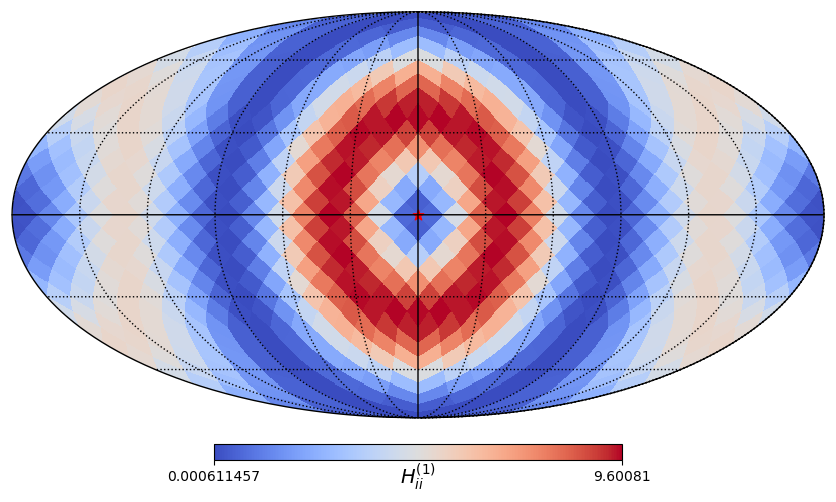

In [6]:
nside = 8 # 
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))
dir = skyvec(theta,phi).reshape(npix,3)



nside_stars = 8
nstars = hp.nside2npix(nside_stars)
stars_idx = np.arange(nstars)
stars_vec = np.array(hp.pix2vec(nside_stars,stars_idx)).T

######### Ameek's values #########
theta1, phi1 = (np.pi/2, 0)
n1 = skyvec(theta1,phi1)#.reshape(3,1)

theta0 = np.deg2rad(48) 
phi0 = np.deg2rad(264)
# vvec = np.array([0,0,1])
#vvec = skyvec(theta0,phi0).reshape(3,1)
##################################

v = skyvec(v_theta, v_phi)#.reshape(3,1)


print('v shape:',np.shape(v))
print('dir shape:',np.shape(dir))
print('v', v)

f = lambda q: K0_analytical(n1, q)
map_stars_K0K0 = vmap(f, in_axes=(0),out_axes=(-1))(stars_vec)

#Map_K0K0 = K0_analytical(n1,dir)

#print(Map_H1H1)

hp.mollview(map_stars_K0K0,title=r'',cmap='coolwarm',cbar=True, unit=r'$H^{(1)}_{ii}$')
#hp.mollview(Map_K0K0, title=r'',cmap='coolwarm',cbar=True, unit=r'$H^{(1)}_{ii}$')
hp.projscatter(theta1, phi1,marker='*',s=60,color='r')
hp.graticule()
#min = np.min(Map_TraceHij_1)
#max = np.max(Map_TraceHij_1)
#print('min:',min)
#print('max:',max)

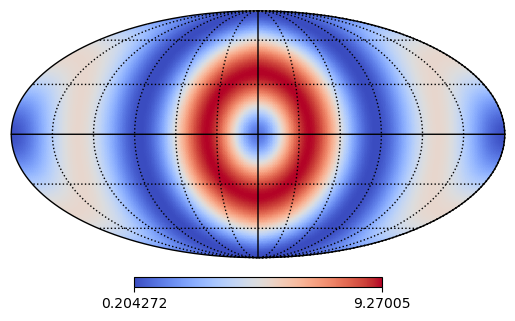

In [7]:
sm = map_stars_K0K0

fwhm = 0.2
up_map = hp.ud_grade(map_stars_K0K0,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)

hp.mollview(sm,cmap='coolwarm',cbar=True,title="",hold=True)
hp.graticule(color='k')

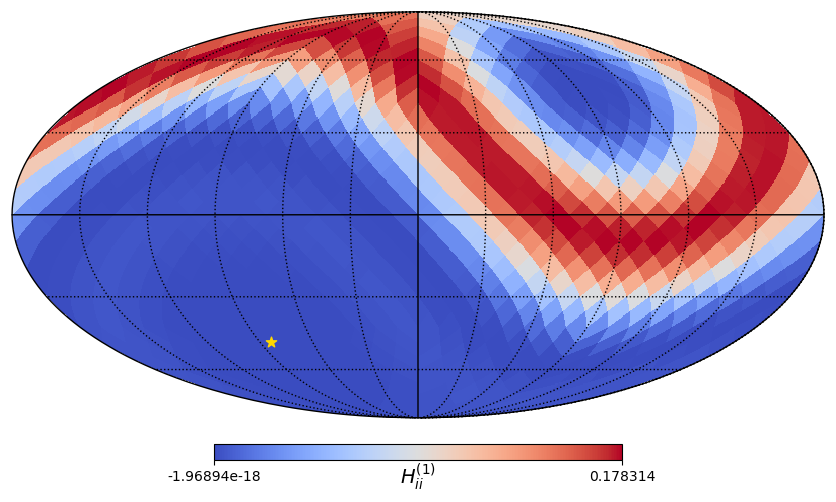

In [22]:
#n2 = jnp.array([-0.18639486, -0.72313051, -0.66508587]) # Orthogonal to V
#n2 = jnp.array([0.96388439, -0.26566278, 0.01871302]) # Random position in the Sky (close to the centre)
n2 = -v # Parallel to V
vcrossn = jnp.array(jnp.cross(v,n2))

theta_n2, phi_n2 = hp.vec2ang(n2)


f = lambda q: Hdipole_analytical(n2, q, vcrossn)
Map_H1H1 = vmap(f, in_axes=(0),out_axes=(-1))(stars_vec)

hp.mollview(Map_H1H1, title=r'', cmap='coolwarm', cbar=True, unit=r'$H^{(1)}_{ii}$')
hp.projscatter(theta_n2, phi_n2, marker='*',s=60,color='gold')
hp.graticule()

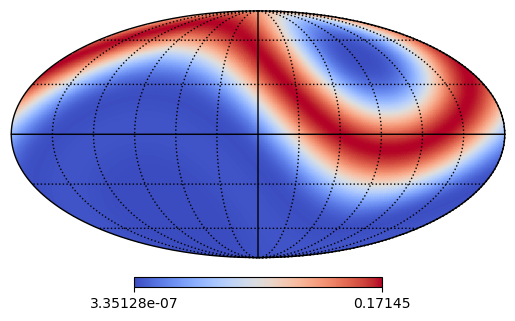

In [23]:
sm = Map_H1H1

fwhm = 0.2
up_map = hp.ud_grade(Map_H1H1,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)

hp.mollview(sm,cmap='coolwarm',cbar=True,title="",hold=True)
hp.graticule(color='k')

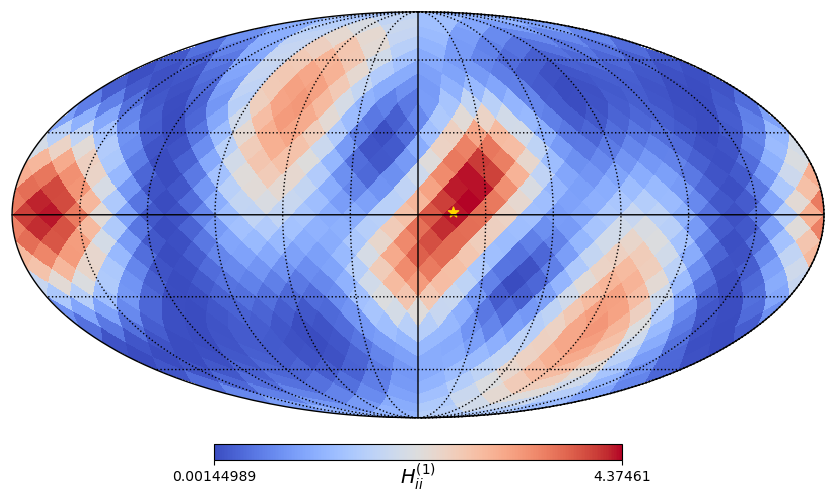

In [17]:
#n2 = jnp.array([-0.18639486, -0.72313051, -0.66508587]) # Orthogonal to V
n2 = jnp.array([0.96388439, -0.26566278, 0.01871302]) # Random position in the Sky (close to the centre)
#n2 = -v # Parallel to V


theta_n2, phi_n2 = hp.vec2ang(n2)


f = lambda q: K1K1_analytical(n2, q, v)
Map_K1K1 = vmap(f, in_axes=(0),out_axes=(-1))(stars_vec)

hp.mollview(Map_K1K1, title=r'', cmap='coolwarm', cbar=True, unit=r'$H^{(1)}_{ii}$')
hp.projscatter(theta_n2, phi_n2, marker='*',s=60,color='gold')
hp.graticule()


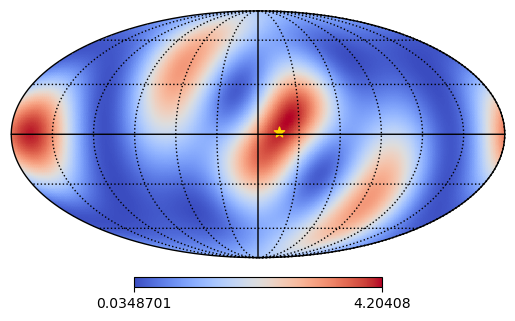

In [18]:
sm = Map_K1K1

fwhm = 0.2
up_map = hp.ud_grade(Map_K1K1,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)

hp.mollview(sm,cmap='coolwarm',cbar=True,title="",hold=True)
hp.projscatter(theta_n2, phi_n2, marker='*',s=60,color='gold')
hp.graticule(color='k')